In [1]:
!pip install albumentations

In [2]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm
import albumentations

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 32
SEED = 1488
IMAGE_SIZE = 380
NUM_CLASSES = 6
TRAIN_IMG_PATH = "/app/_data/380_npy/"
TEST_IMG_PATH = "/app/_data/test_images/"
feature_columns = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [4]:
wrong = ['ead085dfac287263.jpg', '95276ccd226ad933.jpg', 'da8770e819d2696d.jpg']
df_labels = pd.read_csv('../_data/df_csv/train.csv')
test_20_labeled = pd.read_csv('../_data/df_csv/test20_labeled.csv', index_col=[0])
new_images = pd.read_csv('/app/_data/df_csv/new_images1.csv')
duplicates_labeled = pd.read_csv('/app/_data/df_csv/duplicates_labeled.csv')
duplicates_labeled = duplicates_labeled.dropna(axis=0).reset_index(drop=True)

In [5]:
# for i in range(duplicates_labeled.shape[0]):
#     img_name = duplicates_labeled.loc[i, 'image']
#     img_name = img_name.split('_')[0]+'.jpg'
#     duplicates_labeled.loc[i, 'image'] = img_name

In [6]:
# duplicates_labeled.to_csv('/app/_data/df_csv/duplicates_labeled.csv', index=False)

In [7]:
df_labels = pd.concat([df_labels, test_20_labeled[['image','labels']], new_images], axis=0, ignore_index = True)
df_labels = df_labels.query('image not in @wrong').reset_index(drop=True)
list_dup = duplicates_labeled['image'].tolist()
df_labels = df_labels.query('image not in @list_dup').reset_index(drop=True)
df_labels = pd.concat([df_labels,duplicates_labeled], axis=0, ignore_index = True)
df_labels = df_labels.join(df_labels['labels'].str.get_dummies(' '))
df_labels['image'] = df_labels['image'].str.replace('.jpg', '.npy')
df_complex = df_labels.query('labels == "complex"').reset_index(drop=True)
df_without_complex = df_labels.query('labels != "complex"').reset_index(drop=True)

In [8]:
df_complex['image']

0       800cbf0ff87721f8.npy
1       801f78399a44e7af.npy
2       802291cee9fec9f4.npy
3       803e3bd17a16e65c.npy
4       8052c7272b3b3f5c.npy
                ...         
1577    f3dc17a2b20d48ec.npy
1578    d3945c098edc9dd1.npy
1579    dea33c5c0347aa4d.npy
1580    e59e94b8c813b873.npy
1581    a3bb604d8a55995d.npy
Name: image, Length: 1582, dtype: object

In [9]:
# for 380*380
transform = albumentations.Compose(
    [
        albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
        albumentations.OneOf(
            [
                albumentations.MotionBlur((3, 3)),
                albumentations.MedianBlur(blur_limit=3),
                albumentations.GaussianBlur(
                    blur_limit=(3, 3), sigma_limit=0),
                albumentations.Blur(blur_limit=(3, 3)),
            ],
            p=0.2,
        ),
        albumentations.OneOf(
            [
                albumentations.GaussNoise(var_limit=[10, 50], mean=1),
                albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.01, 0.05)),
                albumentations.ImageCompression(
                    quality_lower=70, quality_upper=100, compression_type=1
                ),
                albumentations.MultiplicativeNoise(
                    multiplier=(0.95, 1.05), per_channel=True, elementwise=True
                ),
                albumentations.Downscale(
                    scale_min=0.6, scale_max=0.99, interpolation=4
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=(-7, 7),
                    sat_shift_limit=(-10, 10),
                    val_shift_limit=(-10, 10),
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.15,
                    contrast_limit=0.2,
                    brightness_by_max=True,
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.OpticalDistortion(
                    distort_limit=0.05,
                    shift_limit=0.05,
                    border_mode=2,
                ),
                albumentations.ElasticTransform(
                    alpha=2.0,
                    sigma=50.0,
                    alpha_affine=10.0,
                    interpolation=0,
                    border_mode=2,
                ),
                albumentations.GridDistortion(
                    num_steps=5, distort_limit=0.3, interpolation=0, border_mode=2
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Rotate(
                    limit=(-180, 180), interpolation=0, border_mode=2
                ),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=180,
                    interpolation=0,
                    border_mode=2,
                ),
            ],
            p=0.5,
        ),
    ]
)

In [10]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        images_src_dir,
        batch_size,
        target_image_size,
        shuffle=False,
        augment = True,
        crop = False,
        resize=False,
        normalize=False
    ):
        self.shuffle = shuffle
        self.batch_size = BATCH_SIZE
        self.df = df
        self.images_dir = images_src_dir
        self.target_image_size = (IMAGE_SIZE, IMAGE_SIZE)
        self.augment = augment
        self.crop = crop
        self.resize = resize
        self.normalize = normalize
        # create label index map
        self.labels = self._read_labels()
        self.n_samples = self.df.shape[0]
        self.n_batches = self.n_samples // self.batch_size
        # shuffle data, also repeated after each epoch if needed
        if self.shuffle:
            np.random.shuffle(self.labels)

    def _read_labels(self):
        """
        Returns list images mapping to 1-hot label
        """


        # label indexes 
        label_ixs = self.df[feature_columns].values
        image_ixs = self.df['image'].values
        labels = []

        for i in range(len(image_ixs)):
            labels.append([image_ixs[i], label_ixs[i]])
        return labels
    
    def __len__(self):
        """
        Length in batches
        """
        return self.n_batches

    def __getitem__(self, b_ix):
        """
        Produce batch, by batch index
        """

        assert b_ix < self.n_batches

        b_X = np.zeros(
            (self.batch_size, self.target_image_size[0], self.target_image_size[1], 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.df[feature_columns].shape[1]),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i], b_Y[i] = self.get_one(
                i + self.batch_size * b_ix,
            )

        return (b_X, b_Y)

    def get_one(
        self, one_ix
    ):
        """
        Get single item by absolute index
        """
        id = self.labels[one_ix][0]
        src_file = self.images_dir+id

        # read file
        x = np.load(src_file)
        if self.crop:
            coord = self.df[self.df["image"] == id][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
            orig_hight = x.shape[0]
            orig_width = x.shape[1]
            x_min = coord[0]
            y_min = coord[1]
            x_max = coord[2]
            y_max = coord[3]
            x = x[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]

        y = self.labels[one_ix][1]

        # augment
        if self.augment:
            x = self._augment_image(x)

        # normalize (sample-wise)
        if self.normalize:
            x = x.astype(np.float32)
            x = x - np.mean(x, axis=(0, 1))
            x = x / np.std(x, axis=(0, 1))
        return x.astype(np.uint8), y

    def _augment_image(self, x):
        """
        Randomply augment image
        """

        x = transform(image=x)['image']
        return x

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.labels)

In [11]:
gen = Generator(
    df=df_labels.head(1).sample(100, replace=True),
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False
)

In [12]:
gen.labels[9]

['800113bb65efe69e.npy', array([0, 0, 1, 0, 0, 0])]

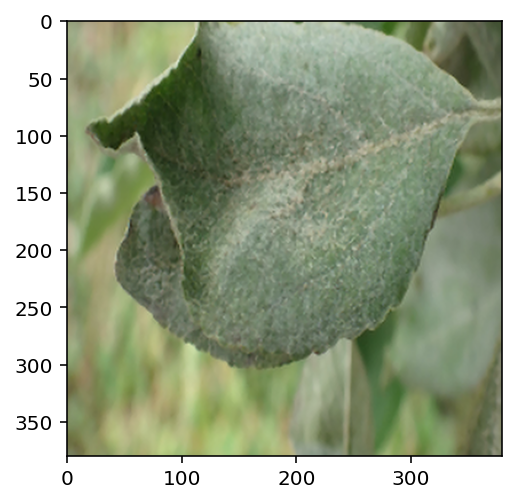

In [13]:
# img = Image.open(gen_train.get_one(1)[0])
plt.imshow(gen.get_one(1)[0])

# StratifiedShuffleSplit

In [14]:
# df_without_complex
train, valid = train_test_split(df_without_complex, train_size=0.8, random_state=SEED)

In [15]:
gen_train = Generator(
    df=train,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False, resize=False
)

In [16]:
gen_valid = Generator(
    df=valid,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=False, augment=False, crop=False, resize=False
)

In [17]:
len(gen_valid.labels)

3674

In [18]:
x0, y0 = gen_train.get_one(55)

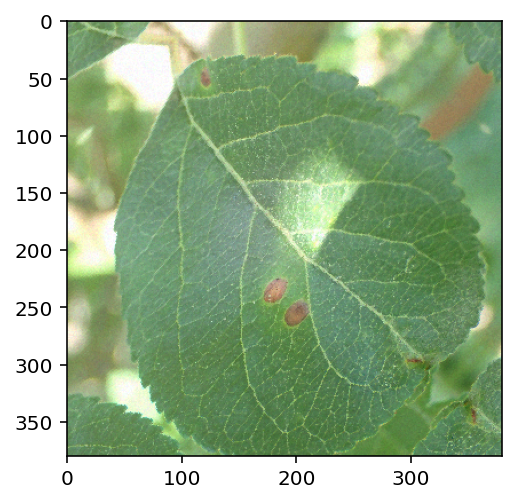

In [19]:
plt.imshow(x0)

In [20]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/albumentations/eff4_ns_cr_complex_2.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.5,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
]

In [24]:
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)

In [25]:
# inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights(
#     "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
#     by_name=True,
#     skip_mismatch=True,
# )
# x = base_model(inputs)
# x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
# x = keras.layers.Flatten(name="flatten")(x)
# outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
# model.compile(
#     loss="binary_crossentropy",
#     optimizer=Adam(lr=0.0005),
#     metrics=[
#         "acc",
#         keras.metrics.Recall(),
#         keras.metrics.Precision(),
#         tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
#     ],
# )

In [27]:
# history = model.fit(
#     gen_train,
#     validation_data=gen_valid,
#     epochs=100,
#     steps_per_epoch=(train.shape[0] * 0.8) // BATCH_SIZE,
#     validation_steps=(valid.shape[0] * 0.2) // BATCH_SIZE,
#     verbose=1,
#     use_multiprocessing=True,
#     callbacks=callbacks,
# )

In [28]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [29]:
# plot_curves(history, loss=False)

In [30]:
model = keras.models.load_model('/app/_data/models/albumentations/eff4_ns_cr_complex_1.h5')

In [31]:
# def pred_to_labels(pred, thresh=0.5, labels=feature_columns):
#     pred = [labels[i] for i in range(len(labels)) if pred[i] > thresh]
#     pred = " ".join(pred)
#     return pred
# def predict_new(path, model):
#     img = np.load(TRAIN_IMG_PATH+path)
#     img = tf.expand_dims(img,axis = 0)
#     pred = model.predict(img)
#     return pred_to_labels(pred[0])

In [32]:
# a = predict_new('9eb93fe282326266.jpg', model)

In [33]:
# df_sub = pd.DataFrame(columns=['image','labels'])
# for img_name in df_complex['image'].tolist():
#     pred = predict_new(img_name, model)

#     df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )

# print(df_sub.head())


In [34]:
# df_sub = df_sub.join(df_sub['labels'].str.get_dummies(' '))

In [35]:
# len(df_sub[df_sub['complex']==1])

In [38]:
df_sub= pd.read_csv("/app/_data/df_csv/complex_predicted_1.csv", index_col=[0])

In [40]:
df_sub['complex']=1

In [41]:
df_sub

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800cbf0ff87721f8.npy,complex frog_eye_leaf_spot scab,1,1,0,0,0,1
1,801f78399a44e7af.npy,frog_eye_leaf_spot scab,1,1,0,0,0,1
2,802291cee9fec9f4.npy,frog_eye_leaf_spot scab,1,1,0,0,0,1
3,803e3bd17a16e65c.npy,complex frog_eye_leaf_spot scab,1,1,0,0,0,1
4,8052c7272b3b3f5c.npy,frog_eye_leaf_spot scab,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...
1577,f3dc17a2b20d48ec.npy,complex scab,1,0,0,0,0,1
1578,d3945c098edc9dd1.npy,scab,1,0,0,0,0,1
1579,dea33c5c0347aa4d.npy,scab,1,0,0,0,0,1
1580,e59e94b8c813b873.npy,healthy,1,0,1,0,0,0


In [46]:
# v1 without filling complex

In [42]:
df_all = pd.concat([df_without_complex, df_sub], axis=0, ignore_index=True)

In [43]:
df_all = df_all.sample(frac=1)

In [44]:
df_all

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
14967,f434f0441f871e9b.npy,rust,0,0,0,0,1,0
18404,82d0dd9cb978e558.npy,frog_eye_leaf_spot scab,1,1,0,0,0,1
8902,c3d2d9ad61c2e351.npy,scab,0,0,0,0,0,1
14476,f09047534b76db29.npy,scab frog_eye_leaf_spot,0,1,0,0,0,1
5169,aaabb570d0d0eb15.npy,rust,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
2798,97abdad2485a4b25.npy,healthy,0,0,1,0,0,0
10582,d0fdf6e5d8a81501.npy,healthy,0,0,1,0,0,0
13458,e89bc56d1f0c6968.npy,rust,0,0,0,0,1,0
15395,f5fe80820aed1de8.npy,scab,0,0,0,0,0,1


# StratifiedShuffleSplit

In [45]:
# df_without_complex
train, valid = train_test_split(df_all, train_size=0.8, random_state=SEED)

In [46]:
gen_train = Generator(
    df=train,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False, resize=False
)

In [47]:
gen_valid = Generator(
    df=valid,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=False, augment=False, crop=False, resize=False
)

In [48]:
len(gen_valid.labels)

3990

In [49]:
x0, y0 = gen_train.get_one(55)

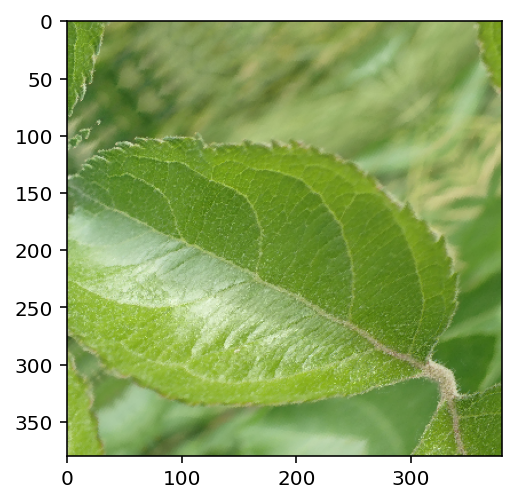

In [50]:
plt.imshow(x0)

In [51]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

In [52]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/albumentations/eff4_ns_cr_pr_complex_2.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.5,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
]

In [24]:
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)

In [53]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
base_model.load_weights(
    "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
    by_name=True,
    skip_mismatch=True,
)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model_complex = keras.Model(inputs=inputs, outputs=outputs)

In [54]:
model_complex.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=[
        "acc",
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
    ],
)

In [ ]:
history = model_complex.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=(train.shape[0] * 0.8) // BATCH_SIZE,
    validation_steps=(valid.shape[0] * 0.2) // BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/100
398/398 [==============================] - ETA: 0s - loss: 0.1554 - acc: 0.7916 - recall: 0.8174 - precision: 0.8841 - f1_score: 0.7852WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_f1_score improved from -inf to 0.84895, saving model to /app/_data/models/albumentations/eff4_ns_cr_pr_complex_2.h5
398/398 [==============================] - 403s 1s/step - loss: 0.1554 - acc: 0.7916 - recall: 0.8174 - precision: 0.8841 - f1_score: 0.7852 - val_loss: 0.1045 - val_acc: 0.8581 - val_recall: 0.8814 - val_precision: 0.9386 - val_f1_score: 0.8489
Epoch 2/100
398/398 [==============================] - ETA: 0s - loss: 0.1007 - acc: 0.8386 - recall: 0.8914 - precision: 0.9225 - f1_score: 0.8342WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recom